# Fitting a simple shock model to the stock price of "Slack Technologies"

Here we will fit a very simple "shock model" to the stock price of _Slack Technologies_ from the 27th of august 2020 to the 31st of march 2021. 

We will try to capture the shock induces by the spearing of rumors on the 25th of november 2020 that _Salesforce_ was interested in buying Slack. More info can be found here https://www.cnbc.com/2020/11/25/slack-shares-jump-following-report-of-possible-salesforce-acquisition.html.

In [1]:
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Slack stock price')

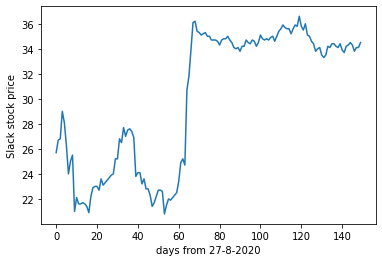

In [2]:
slack_shock_data = np.atleast_2d(np.loadtxt("data/slack_shock.txt")).T
plt.plot(slack_shock_data)
plt.xlabel("days from 27-8-2020")
plt.ylabel("Slack stock price")

### Model

In [3]:
# a simple model of a simple step function with three parameters
def step_func(theta, N, seed=None):
    # [tau, d1, d2]

    e = np.zeros(N)
    tau = int(theta[0])  # day of the sudden change in evaluation
    d1, d2 = theta[1], theta[2]  # initial and final stock prices

    e[0:tau] = d1
    e[tau:] = d2

    return np.atleast_2d(e).T

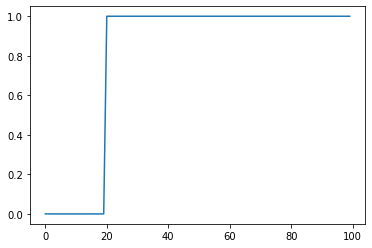

In [4]:
plt.plot(step_func([20, 0, 1], 100))

### parameter bounds and precisions

In [5]:
bounds = [[0, 20, 20],[150, 40, 40]]
precisions = [1, 0.25, 0.25]

In [6]:
bounds

[[0, 20, 20], [150, 40, 40]]

### samplers

In [7]:
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.best_batch import BestBatchSampler

In [8]:
hs = HaltonSampler(batch_size=16)
rf = RandomForestSampler(batch_size=16)
bb = BestBatchSampler(batch_size=16)

samplers = [hs, rf, bb]

### loss

In [9]:
# use a quadratic loss
from black_it.loss_functions.minkowski import MinkowskiLoss

loss = MinkowskiLoss()

### calibrator

In [10]:
from black_it.calibrator import Calibrator

In [11]:
cal = Calibrator(
    samplers=samplers,
    loss_function=loss,
    model=step_func,
    parameters_bounds=bounds,
    parameters_precision=precisions,
    ensemble_size=1,
    convergence_precision=None,
    verbose=True,
    saving_folder=None,
    real_data=slack_shock_data,
    random_state=1,
)


***
Number of free params:       3.
Explorable param space size: 990711.
***

Selecting 8 processes for the parallel evaluation of the model


### Calibration

In [12]:
params, losses = cal.calibrate(10)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HaltonSampler
----> sim exec elapsed time: 0.3s
---->   min loss new params: 48.81
---->   avg loss new params: 93.88
----> avg loss exist params: 93.88
---->         curr min loss: 48.81198552405123
====>    total elapsed time: 0.3s

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 46.24
---->   avg loss new params: 66.12
----> avg loss exist params: 80.0
---->         curr min loss: 46.23645638238496
====>    total elapsed time: 2.1s

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 41.37
---->   avg loss new params: 59.29
----> avg loss exist params: 73.1
---->         curr min loss: 41.374024300280325
====>    total elapsed time: 0.0s

BATCH NUMBER:   2
PARAMS SAMPLED: 48

METHOD: HaltonSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 59.83
---->   avg loss new params: 100.14
----> avg loss exist params: 79.86
---->         curr min lo

----> sim exec elapsed time: 0.0s
---->   min loss new params: 23.68
---->   avg loss new params: 35.37
----> avg loss exist params: 56.6
---->         curr min loss: 18.777912631604902
====>    total elapsed time: 2.1s

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 18.78
---->   avg loss new params: 27.49
----> avg loss exist params: 55.63
---->         curr min loss: 18.777912631604902
====>    total elapsed time: 0.1s


In [13]:
# best parameters obtained so far
params[0]

array([64., 24., 35.])

### plots

In [14]:
# index of mimumum loss
idxmin = np.argmin(cal.losses_samp)
param_min = cal.params_samp[idxmin]

In [15]:
# convergence
losses_per_batch = [
    cal.losses_samp[cal.batch_num_samp == i]
    for i in range(int(max(cal.batch_num_samp)) + 1)
]
mins_per_batch = np.array([np.min(l) for l in losses_per_batch])
cummin_per_batch = [
    np.min(mins_per_batch[: i + 1]) for i in range(mins_per_batch.shape[0])
]

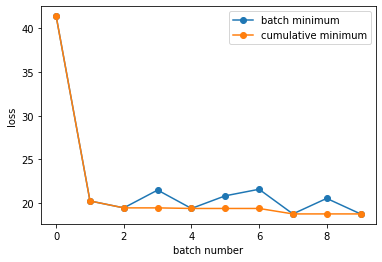

In [16]:
plt.figure()
plt.plot(mins_per_batch, "-o", label="batch minimum")
plt.plot(cummin_per_batch, "-o", label="cumulative minimum")
plt.ylabel("loss")
plt.xlabel("batch number")
plt.legend()

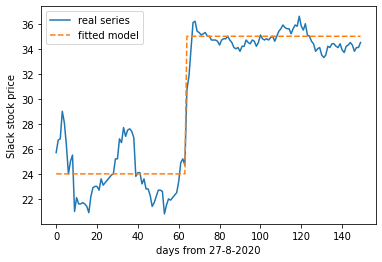

In [17]:
# agreement between real and simulated time series

plt.plot(slack_shock_data[:, 0], "-", label="real series")
plt.ylabel(
    "Slack stock price",
)
plt.xlabel("days from 27-8-2020")


plt.plot(cal.series_samp[idxmin, 0, :, 0].T, ls="--", label="fitted model")
plt.legend()